# Desafio 5

Neste desafio, vamos praticar sobre redução de dimensionalidade com PCA e seleção de variáveis com RFE. Utilizaremos o _data set_ [Fifa 2019](https://www.kaggle.com/karangadiya/fifa19), contendo originalmente 89 variáveis de mais de 18 mil jogadores do _game_ FIFA 2019.

> Obs.: Por favor, não modifique o nome das funções de resposta.

## _Setup_ geral

In [17]:
from math import sqrt
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as sct
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats as st
from sklearn.decomposition import PCA
from sklearn.datasets import load_digits
from loguru import logger
from yellowbrick.model_selection import RFECV

c:\users\marin.desktop-jcc1rh5\miniconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
# Algumas configurações para o matplotlib.
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12, 8)
sns.set()

In [4]:
fifa = pd.read_csv("fifa.csv")

In [7]:
columns_to_drop = ["Unnamed: 0", "ID", "Name", "Photo", "Nationality", "Flag",
                   "Club", "Club Logo", "Value", "Wage", "Special", "Preferred Foot",
                   "International Reputation", "Weak Foot", "Skill Moves", "Work Rate",
                   "Body Type", "Real Face", "Position", "Jersey Number", "Joined",
                   "Loaned From", "Contract Valid Until", "Height", "Weight", "LS",
                   "ST", "RS", "LW", "LF", "CF", "RF", "RW", "LAM", "CAM", "RAM", "LM",
                   "LCM", "CM", "RCM", "RM", "LWB", "LDM", "CDM", "RDM", "RWB", "LB", "LCB",
                   "CB", "RCB", "RB", "Release Clause"
]

try:
    fifa.drop(columns_to_drop, axis=1, inplace=True)
except KeyError:
    logger.warning(f"Columns already dropped")
    

2020-07-17 13:27:48.804 | WARNING  | __main__:<module>:14 - Columns already dropped


## Inicia sua análise a partir daqui

In [8]:
print("----------Top-5- Record----------")
print(fifa.head(5))
print("-----------Information-----------")
print(fifa.info())
print("-----------Data Types-----------")
print(fifa.dtypes)
print("----------Missing value-----------")
print(fifa.isnull().sum())
print("----------Null value-----------")
print(fifa.isna().sum())
print("----------Shape of Data----------")
print(fifa.shape)

----------Top-5- Record----------
   Age  Overall  Potential  Crossing  Finishing  HeadingAccuracy  \
0   31       94         94      84.0       95.0             70.0   
1   33       94         94      84.0       94.0             89.0   
2   26       92         93      79.0       87.0             62.0   
3   27       91         93      17.0       13.0             21.0   
4   27       91         92      93.0       82.0             55.0   

   ShortPassing  Volleys  Dribbling  Curve  ...  Penalties  Composure  \
0          90.0     86.0       97.0   93.0  ...       75.0       96.0   
1          81.0     87.0       88.0   81.0  ...       85.0       95.0   
2          84.0     84.0       96.0   88.0  ...       81.0       94.0   
3          50.0     13.0       18.0   21.0  ...       40.0       68.0   
4          92.0     82.0       86.0   85.0  ...       79.0       88.0   

   Marking  StandingTackle  SlidingTackle  GKDiving  GKHandling  GKKicking  \
0     33.0            28.0           26.

In [9]:
# Sua análise começa aqui.
# Remover linhas com valores faltantes
fifa.dropna(axis=0, how='any',inplace=True)

In [10]:
fifa.head(5)

,Age,Overall,Potential,Crossing,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,31,94,94,84.0,95.0,70.0,90.0,86.0,97.0,93.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,33,94,94,84.0,94.0,89.0,81.0,87.0,88.0,81.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,26,92,93,79.0,87.0,62.0,84.0,84.0,96.0,88.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,27,91,93,17.0,13.0,21.0,50.0,13.0,18.0,21.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,27,91,92,93.0,82.0,55.0,92.0,82.0,86.0,85.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [11]:
fifa_pivot = pd.DataFrame({'columns': fifa.columns,
                           'types': fifa.dtypes,
                           'nulls': fifa.isna().sum(),
                           '% nulls': fifa.isna().sum() / fifa.shape[0],
                           'size': fifa.shape[0],
                           'uniques': fifa.nunique()})
fifa_pivot

,columns,types,nulls,% nulls,size,uniques
Age,Age,int64,0,0.0,18159,29
Overall,Overall,int64,0,0.0,18159,48
Potential,Potential,int64,0,0.0,18159,47
Crossing,Crossing,float64,0,0.0,18159,89
Finishing,Finishing,float64,0,0.0,18159,93
HeadingAccuracy,HeadingAccuracy,float64,0,0.0,18159,91
ShortPassing,ShortPassing,float64,0,0.0,18159,85
Volleys,Volleys,float64,0,0.0,18159,87
Dribbling,Dribbling,float64,0,0.0,18159,94
Curve,Curve,float64,0,0.0,18159,89


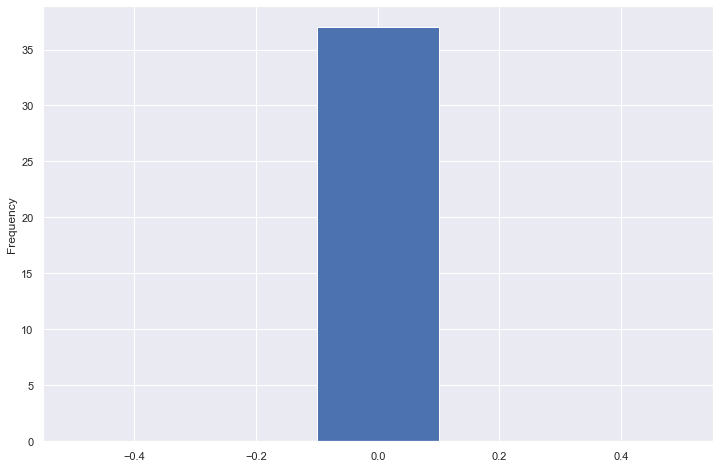

In [12]:
fifa_pivot['% nulls'].plot.hist(bins=5)

## Questão 1

Qual fração da variância consegue ser explicada pelo primeiro componente principal de `fifa`? Responda como um único float (entre 0 e 1) arredondado para três casas decimais.

In [39]:
def q1():
    pca = PCA().fit(fifa)
    return float(pca.explained_variance_ratio_[0].round(3))

## Questão 2

Quantos componentes principais precisamos para explicar 95% da variância total? Responda como un único escalar inteiro.

In [40]:
def q2():
    pca = PCA(n_components=0.95)
    fifa_reduced = pca.fit_transform(fifa)
    return fifa_reduced.shape[1]

In [13]:
pca = PCA().fit(fifa)
evr = pca.explained_variance_ratio_

Text(0, 0.5, 'Cumulative explained variance')

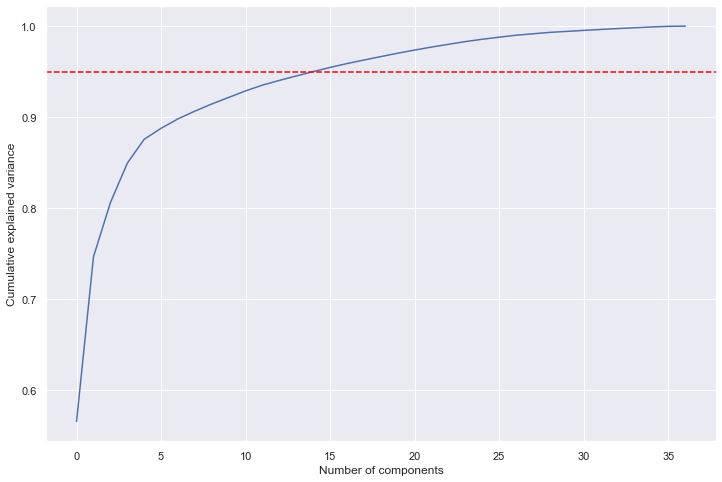

In [14]:
g = sns.lineplot(np.arange(len(evr)), np.cumsum(evr))
g.axes.axhline(0.95, ls="--", color="red")
plt.xlabel('Number of components')
plt.ylabel('Cumulative explained variance')

## Questão 3

Qual são as coordenadas (primeiro e segundo componentes principais) do ponto `x` abaixo? O vetor abaixo já está centralizado. Cuidado para __não__ centralizar o vetor novamente (por exemplo, invocando `PCA.transform()` nele). Responda como uma tupla de float arredondados para três casas decimais.

In [41]:
x = [0.87747123,  -1.24990363,  -1.3191255, -36.7341814,
     -35.55091139, -37.29814417, -28.68671182, -30.90902583,
     -42.37100061, -32.17082438, -28.86315326, -22.71193348,
     -38.36945867, -20.61407566, -22.72696734, -25.50360703,
     2.16339005, -27.96657305, -33.46004736,  -5.08943224,
     -30.21994603,   3.68803348, -36.10997302, -30.86899058,
     -22.69827634, -37.95847789, -22.40090313, -30.54859849,
     -26.64827358, -19.28162344, -34.69783578, -34.6614351,
     48.38377664,  47.60840355,  45.76793876,  44.61110193,
     49.28911284
]

In [42]:
def q3():
    pca = PCA(n_components=2).fit(fifa)
    return tuple(pca.components_.dot(x).round(3))

## Questão 4

Realiza RFE com estimador de regressão linear para selecionar cinco variáveis, eliminando uma a uma. Quais são as variáveis selecionadas? Responda como uma lista de nomes de variáveis.

In [19]:
regression = LinearRegression()

X = fifa.drop(columns='Overall')
y = fifa['Overall']

In [20]:
def q4():
    rfe = RFE(regression, n_features_to_select=5)
    rfe = rfe.fit(X, y)
    return list(X.loc[:, rfe.support_].columns)

c:\users\marin.desktop-jcc1rh5\miniconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)
c:\users\marin.desktop-jcc1rh5\miniconda3\lib\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


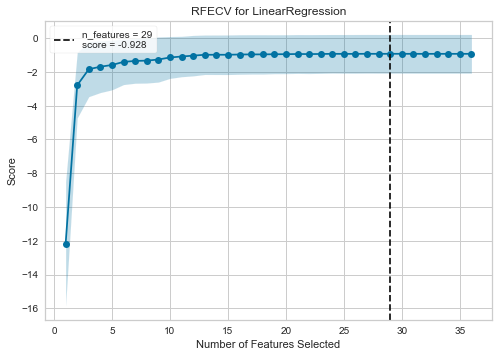

In [21]:
visualizer = RFECV(regression)
visualizer.fit(X, y)
visualizer.show()